<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Lab: Building Advanced Transformers**

**Estimated time needed:  30 minutes**  

In this lab, you will implement and experiment with advanced Transformer models using Keras. 

**Learning objectives:** 

By the end of this lab, you will be able to:

- Understand the core components of a Transformer architecture.
- Implement a multi-head self-attention mechanism from scratch.
- Train and evaluate a Transformer for time series prediction.
- Handle preprocessing and scaling for time series data effectively.


## What is a Transformer?

The Transformer architecture was introduced in the paper *"Attention Is All You Need"*. It revolutionized natural language processing by using attention mechanisms instead of recurrence.

### Key Components:
- **Input Embedding:** Converts input tokens (or time steps) into vectors.
- **Positional Encoding:** Injects information about the position of input tokens.
- **Multi-Head Self-Attention:** Allows the model to focus on different parts of the input sequence.
- **Feedforward Layers:** Process the attended information.
- **Layer Normalization & Residual Connections:** Stabilize and speed up training.

> Transformers are now widely used not only in NLP but also in time series forecasting, image recognition, and more.

**Next:** You will implement parts of this architecture step-by-step.


## Step-by-Step Instructions: 

### Step 1: Import necessary libraries 

Before you start, you need to import the required libraries: TensorFlow and Keras. Keras is included within TensorFlow as `tensorflow.keras.`


In [ ]:
%pip install tensorflow  
%pip install pyarrow
%pip install pandas  
%pip install scikit-learn 
%pip install matplotlib 
%pip install requests

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import requests
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

2025-05-19 21:03:07.249196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747699387.268484   13781 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747699387.274161   13781 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747699387.288570   13781 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747699387.288592   13781 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747699387.288594   13781 computation_placer.cc:177] computation placer alr

####  Setup the Environment to generate synthetic stock price data


In [2]:
import numpy as np
import pandas as pd

# Create a synthetic stock price dataset
np.random.seed(42)
data_length = 2000  # Adjust data length as needed
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

# Create a DataFrame and save as 'stock_prices.csv'
data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)
print("Synthetic stock_prices.csv created and loaded.")

Synthetic stock_prices.csv created and loaded.


In [3]:
data.head(10)

,Close
0,100.993428
1,99.773496
2,101.395427
3,103.196135
4,99.731793
5,99.781851
6,103.458576
7,101.885045
8,99.461251
9,101.535345


In [4]:
print(data.size)

2000


In [5]:
# Load the dataset 
data = pd.read_csv('stock_prices.csv') 
data = data[['Close']].values 

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Prepare the data for training
def create_dataset(data, time_step=1):
    X, Y = [], []

    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape) 

Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


In the above code: 

`tensorflow` is the main library for machine learning in Python.  

`stock_prices.csv` is the data set that is loaded. 

`MinMaxScaler` method is used to normalize the data.  

`create_dataset`method is used to prepare the data for training. 


### Step 2: Implement Multi-Head Self-Attention 

Define the Multi-Head Self-Attention mechanism. 


In [ ]:
class MultiHeadSelfAttention(Layer): 

    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 

    # For each word (query), which other words (keys) should i pay attention to, and how much?
    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 

    # For each attention head, learn different patterns in different regions of the sequence
    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 

    # Makes it possible for the model to focus on multiple positions and interactions in the sequence
    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 

        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 

        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        
        return output 

 

In the above code: 

- The MultiHeadSelfAttention layer implements the multi-head self-attention mechanism, which allows the model to focus on different parts of the input sequence simultaneously. 

- The attention parameter computes the attention scores and weighted sum of the values. 

- The split_heads parameter splits the input into multiple heads for parallel attention computation. 

- The call method applies the self-attention mechanism and combines the heads. 


### Step 3: Implement Transformer block 

Define the Transformer block. 


In [9]:
class TransformerBlock(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 


    def call(self, inputs, training): 
        # Attention output - normalized
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 

        # Feed foward output
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 

        return self.layernorm2(out1 + ffn_output) 

In the above code:

- The TransformerBlock layer combines multi-head self-attention with a feed-forward neural network and normalization layers.  

- Dropout is used to prevent overfitting. 

- Both sub-layers have residual connections around them, and layer normalization is applied to the output of each sub-layer. 

- The call method applies the self-attention, followed by the feedforward network, with residual connections and layer normalization. 


### Step 4: Implement a full Transformer encoder 

Using the previous classes


In [10]:
import tensorflow as tf 
from tensorflow.keras.layers import Layer, Dropout 

class TransformerEncoder(Layer): 
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerEncoder, self).__init__() 
        self.num_layers = num_layers 
        self.embed_dim = embed_dim 
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)] 
        self.dropout = Dropout(rate) 

    def call(self, inputs, training=False): 
        x = inputs 
        for i in range(self.num_layers): 
            x = self.enc_layers[i](x, training=training) 
        return x 

# Example usage 
embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 
inputs = tf.random.uniform((1, 100, embed_dim)) 
outputs = transformer_encoder(inputs, training=False)  # Use keyword argument for 'training' 
print(outputs.shape)  # Should print (1, 100, 128) 

I0000 00:00:1747701044.543553   13781 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7797 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


(1, 100, 128)


In the above code: 

The TransformerEncoder is composed of multiple TransformerBlock layers, implementing the encoding part of the Transformer architecture. 


### Step 6: Build and Compile the Transformer model 

Integrate the Transformer Encoder into a complete model for sequential data. 


In [11]:
# Define the necessary parameters 
embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

# Define the Transformer Encoder 
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 

# Build the model 
input_shape = (X.shape[1], X.shape[2]) 
inputs = tf.keras.Input(shape=input_shape) 

# Project the inputs to the embed_dim 
x = tf.keras.layers.Dense(embed_dim)(inputs) 
encoder_outputs = transformer_encoder(x) 
flatten = tf.keras.layers.Flatten()(encoder_outputs) 
outputs = tf.keras.layers.Dense(1)(flatten) 
model = tf.keras.Model(inputs, outputs) 

# Compile the model 
model.compile(optimizer='adam', loss='mse') 

# Summary of the model 
model.summary() 


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In the above code: 

- The Transformer Encoder model defines the necessary parameters, flattens the output, and ends with a dense layer to produce the final output.  

- The model is then compiled with the Adam optimizer and mean squared error loss. 


### Step 7: Train the Transformer model 

Train the model on the prepared dataset. 


In [12]:
# Train the model
model.fit(X, Y, epochs=20, batch_size=32)


Epoch 1/20


I0000 00:00:1747701115.278644   18832 service.cc:152] XLA service 0x7c8e680029c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747701115.278661   18832 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-19 21:31:55.581241: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747701117.105926   18832 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-19 21:32:00.457328: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_93', 1412 bytes spill stores, 1356 bytes spill loads

2025-05-19 21:32:00.613826: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_93'

10/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 37.1961

I0000 00:00:1747701140.784049   18832 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 13.6115

2025-05-19 21:32:24.875553: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_93', 48 bytes spill stores, 48 bytes spill loads

2025-05-19 21:32:25.067915: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_93', 44 bytes spill stores, 44 bytes spill loads

2025-05-19 21:32:26.047508: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6_0', 1100 bytes spill stores, 1872 bytes spill loads

2025-05-19 21:32:26.072767: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 488 bytes spill stores, 488 bytes spill loads

2025-05-19 21:32:26.858439: I external/loc

60/60 ━━━━━━━━━━━━━━━━━━━━ 59s 419ms/step - loss: 13.3111
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1753
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1680
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1976
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1331
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1739
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1629
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1053
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1553
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1210
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1242
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1011
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1130
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1033
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0671
Epoch 16/20


In the above code: 

The model is trained on the normalized stock price data for 20 epochs with a batch size of 32. 


### Step 8: Evaluate and Make Predictions 

Evaluate the model's performance and make predictions on the dataset. 


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


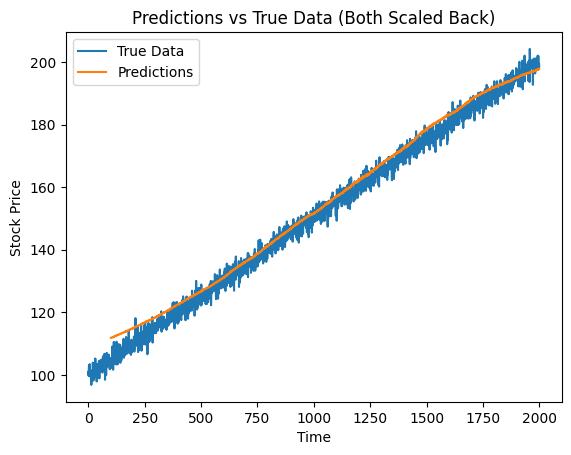

In [13]:
# Make predictions 
predictions = model.predict(X) 
predictions = scaler.inverse_transform(predictions) 

# Prepare true values for comparison
true_values = scaler.inverse_transform(data.reshape(-1, 1))

# Plot the predictions vs true values
import matplotlib.pyplot as plt 

plt.plot(true_values, label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.title('Predictions vs True Data (Both Scaled Back)')
plt.show() 


In the above code: 

- The model's predictions are transformed back to the original scale using the inverse transform of the scaler. 

- The true data and predictions are plotted to visualize the model's performance. 


## Practice Exercises: 

 ### Exercise 1: Add dropout to the Transformer model 

 **Objective: Understand how to add dropout layers to the Transformer model to prevent overfitting.** 

 Instructions: 

- Add a dropout layer after the Flatten layer in the model. 

- Set the dropout rate to 0.5. 


In [15]:
import tensorflow.keras.layers as layers
import tensorflow.keras as keras

embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

# Define the Transformer Encoder 
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 

# Build the model 
input_shape = (X.shape[1], X.shape[2]) 
inputs = keras.Input(shape=input_shape) 

# Project the inputs to the embed_dim 
x = layers.Dense(embed_dim)(inputs) 
encoder_outputs = transformer_encoder(x) 
flatten = layers.Flatten()(encoder_outputs)
dropout = layers.Dropout(0.5)(flatten)
outputs = layers.Dense(1)(dropout)

# Build the model
model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.fit(X, Y, epochs=20,  batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss: {loss}')

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 219ms/step - loss: 16.2362
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6264
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2646
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4604
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9238
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4337
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2246
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1181
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0653
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0556
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0411
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0400
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0266
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0270
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0350
E

<details><summary>Click here to view the solution.</summary>

```
from tensorflow.keras.layers import Dropout 

  

# Add a dropout layer after the Flatten layer 

flatten = tf.keras.layers.Flatten()(encoder_outputs) 

dropout = Dropout(0.5)(flatten) 

outputs = tf.keras.layers.Dense(1)(dropout) 

  

# Build the model 

model = tf.keras.Model(inputs, outputs) 

  

# Compile the model 

model.compile(optimizer='adam', loss='mse') 

  

# Train the model 

model.fit(X, Y, epochs=20, batch_size=32) 

  

# Evaluate the model 

loss = model.evaluate(X, Y) 

print(f'Test loss: {loss}') 

```
</details>


### Exercise 2: Experiment with different batch sizes 

**Objective: Observe the impact of different batch sizes on model performance.** 

 Instructions: 

- Train the model with a batch size of 16. 

- Train the model with a batch size of 64. 

- Compare the training time and performance. 


In [16]:
## Write your code here.
model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.fit(X, Y, epochs=20,  batch_size=16)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss for batch size 16: {loss}')

Epoch 1/20


2025-05-19 21:46:12.828386: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_93_0', 140 bytes spill stores, 140 bytes spill loads

2025-05-19 21:46:13.420089: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_93', 44 bytes spill stores, 44 bytes spill loads

2025-05-19 21:46:14.087972: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 3224 bytes spill stores, 3232 bytes spill loads

2025-05-19 21:46:14.145836: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_87_0', 140 bytes spill stores, 140 bytes spill loads

2025-05-19 21:46:14.154924: I externa

119/119 ━━━━━━━━━━━━━━━━━━━━ 46s 113ms/step - loss: 0.3847
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0380
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0249
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0245
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0573
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0481
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0266
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0235
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0284
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0155
Epoch 11/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0121
Epoch 12/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0142
Epoch 13/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0158
Epoch 14/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0176
Epoch 15/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.01

In [17]:
## Write your code here.
model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.fit(X, Y, epochs=20,  batch_size=64)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss for batch size 64: {loss}')

Epoch 1/20


2025-05-19 21:47:20.453468: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_93', 132 bytes spill stores, 132 bytes spill loads

2025-05-19 21:47:21.257487: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 8 bytes spill stores, 8 bytes spill loads

2025-05-19 21:47:21.359440: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_93', 1412 bytes spill stores, 1356 bytes spill loads

2025-05-19 21:47:21.378680: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 484 bytes spill stores, 484 bytes spill loads

2025-05-19 21:47:22.707389: I external/local

28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4422

2025-05-19 21:47:46.644516: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_93', 44 bytes spill stores, 44 bytes spill loads

2025-05-19 21:47:46.669547: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_93', 48 bytes spill stores, 48 bytes spill loads

2025-05-19 21:47:47.016713: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_93', 124 bytes spill stores, 124 bytes spill loads

2025-05-19 21:47:47.488928: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 488 bytes spill stores, 488 bytes spill loads

2025-05-19 21:47:47.706760: I external/local_

30/30 ━━━━━━━━━━━━━━━━━━━━ 61s 898ms/step - loss: 0.4226
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0229
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0055
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0035
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0029
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0030
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0026
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0023
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023
Epoch 16/20
3

<details><summary>Click here to view the solution.</summary>

```
# Train the model with batch size 16
model.fit(X, Y, epochs=20, batch_size=16)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 16: {loss}')

# Train the model with batch size 64
model.fit(X, Y, epochs=20, batch_size=64)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 64: {loss}')

```
</details>


### Exercise 3: Use a different activation function 

 **Objective: Understand how different activation functions impact the model performance.** 

 Instructions: 

- Change the activation function of the Dense layer to `tanh`. 

- Train and evaluate the model. 


In [20]:
## Write your code here.
outputs = layers.Dense(1, activation='tanh')(flatten)

model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.fit(X, Y, epochs=20,  batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss for tanh activation: {loss}')

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step - loss: 0.1161
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0127
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0101
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0109
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0068
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0041
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0042
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0026
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0023
Ep

<details><summary>Click here to view the solution.</summary>

```
# Change the activation function of the Dense layer to tanh
outputs = tf.keras.layers.Dense(1, activation='tanh')(flatten)

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with tanh activation: {loss}')

```
</details>


## Conclusion
Congratulations on completing this lab! In this lab, you have built an advanced Transformer model using Keras and applied it to a time series forecasting task. You have learned how to define and implement multi-head self-attention, Transformer blocks, encoder layers, and integrate them into a complete Transformer model. By experimenting with different configurations and training the model, you can further improve its performance and apply it to various sequential data tasks. 


Copyright © IBM Corporation. All rights reserved.
